**Neural Chef Assistance**  
**Name: Darren Jer Shien Yee**  
**Student ID: 31237223**

**Implementation of Baseline 1: RNN without Attention**

In [70]:
## Requirements
!pip3 install nltk
!pip3 install tensorboardX
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from tensorboardX import SummaryWriter
import numpy as np
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


**Implementation of Baseline 1: Language Method imported from RNN code provided in tutorials**

In [71]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
        self.unique_words = []

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.unique_words.append(word)
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

**Implementation of Baseline 1: Unicode and ASCII method to preprocess data**

In [72]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
# Lowercase only (since numerical is crucial here as opposed to lab code)
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = s.replace('\t', ' ')
    return s

**Implementation of Baseline 1: Method to read data from provided CSV**

In [213]:
import pandas as pd

def readLangs(reverse=False):
    # Read the CSV file
    train_df = pd.read_csv('Cooking_Dataset/Cooking_Dataset/train.csv')
    valid_df = pd.read_csv('Cooking_Dataset/Cooking_Dataset/dev.csv')
    test_df = pd.read_csv('Cooking_Dataset/Cooking_Dataset/test.csv')
    
    train_df.fillna('', inplace=True)
    valid_df.fillna('', inplace=True)
    test_df.fillna('', inplace=True)
    
    train_ingredients = train_df['Ingredients']
    train_recipes = train_df['Recipe']
    valid_ingredients = valid_df['Ingredients']
    valid_recipes = valid_df['Recipe']    
    test_ingredients = test_df['Ingredients']
    test_recipes = test_df['Recipe']
    
    train_pairs = [[normalizeString(ing), normalizeString(rec)] for ing, rec in zip(train_ingredients, train_recipes)]
    valid_pairs = [[normalizeString(ing), normalizeString(rec)] for ing, rec in zip(valid_ingredients, valid_recipes)]
    test_pairs = [[normalizeString(ing), normalizeString(rec)] for ing, rec in zip(test_ingredients, test_recipes)]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang('Recipe')
        output_lang = Lang('Ingredients')
    else:
        input_lang = Lang('Ingredients')
        output_lang = Lang('Recipe')
    return input_lang, output_lang, train_pairs, valid_pairs, test_pairs

**Implementation of Baseline 1: Preprocess data and intialise language using the methods above**

In [214]:
MAX_LENGTH = 150
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]
    
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, train_pairs, valid_pairs, test_pairs = readLangs(reverse)
    print("Read %s sentence pairs" % len(train_pairs))
    train_pairs = filterPairs(train_pairs)
    valid_pairs = filterPairs(valid_pairs)
    test_pairs = filterPairs(test_pairs)
    print("Trimmed to %s sentence pairs" % len(train_pairs))
    print("Counting words...")
    for pair in train_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in valid_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in test_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, train_pairs, valid_pairs, test_pairs

input_lang, output_lang, train_pairs, valid_pairs, test_pairs = prepareData('ingredients', 'recipe', False)
print(random.choice(train_pairs))

Read 101340 sentence pairs
Trimmed to 79894 sentence pairs
Counting words...
Counted words:
Ingredients 37056
Recipe 35620
['12 oz cream cheese, softened 3/4 c  sugar 1    yolk, slightly beaten', "blend the sugar with the softened cream cheese until thoroughly combined . do n't overbeat or aerate . mix in the yolk . chill until firm ."]


**Implementation of Baseline 1: Encoder RNN for seq2seq model without attention**

In [75]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

**Implementation of Baseline 1: Decoder RNN for seq2seq model without attention**

In [76]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


**Implementation of Baseline 1: Processing methods for train iter**

In [77]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

**Implementation of Baseline 1: Train method for seq2seq model without attention**

In [78]:
teacher_forcing_ratio = 1


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [79]:
def valid(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length


**Implementation of Baseline 1: Time method for train iter method** 

In [80]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

**Implementation of Baseline 1: Train iter method**

In [81]:
def trainIters(encoder, decoder, n_iters,train_pairs,valid_pairs, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_train_losses = []
    plot_valid_losses = []
    print_train_loss_total = 0  # Reset every print_every
    plot_train_loss_total = 0  # Reset every plot_every
    print_valid_loss_total = 0  # Reset every print_every
    plot_valid_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs))
                      for i in range(n_iters)]
    valid_pairs = [tensorsFromPair(random.choice(valid_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        training_input_tensor = training_pair[0]
        training_target_tensor = training_pair[1]

        valid_pair = valid_pairs[iter - 1]
        valid_input_tensor = valid_pair[0]
        valid_target_tensor = valid_pair[1]

        train_loss = train(training_input_tensor, training_target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_train_loss_total += train_loss
        plot_train_loss_total += train_loss
        
        valid_loss = valid(valid_input_tensor, valid_target_tensor, encoder,
             decoder, criterion)
        print_valid_loss_total += valid_loss
        plot_valid_loss_total += valid_loss

        if iter % print_every == 0:
            print_train_loss_avg = print_train_loss_total / print_every
            print_train_loss_total = 0
            print_valid_loss_avg = print_valid_loss_total / print_every
            print_valid_loss_total = 0
            print('%s (%d %d%%) Train Loss: %.4f | Validation Loss: %.4f' % (timeSince(start, iter / n_iters),
                                                                             iter, iter / n_iters * 100,
                                                                             print_train_loss_avg, print_valid_loss_avg))
        if iter % plot_every == 0:
            plot_train_loss_avg = plot_train_loss_total / plot_every
            plot_train_losses.append(plot_train_loss_avg)
            plot_train_loss_total = 0
            
            plot_valid_loss_avg = plot_valid_loss_total / plot_every
            plot_valid_losses.append(plot_valid_loss_avg)
            plot_valid_loss_total = 0
    return plot_train_losses,plot_valid_losses


**Implementation of Baseline 1: Show Plot method**

In [82]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
def showPlot(model_name,points1, points2, epochs, plot_every):
    plt.figure()
    fig, ax = plt.subplots()
    # This locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    x_range = np.array(np.arange(0, epochs-1, plot_every))
    plt.plot(x_range,points1, label='Train')  # Plot points1 with label 'Train'
    plt.plot(x_range,points2, label='Valid')  # Plot points2 with label 'Valid'
    plt.legend()  # Add legend
    plt.xlabel('Epochs')  # Label x-axis
    plt.ylabel('Loss')  # Label y-axis
    plt.title(model_name+' Training and Validation Loss')  # Set title for the plot
    plt.show()

**Implementation of Baseline 1: Evaluation methods to check performance of baseline 1**

In [83]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [84]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

**Implementation of Baseline 1: Creating instance of baseline 1 and training**

In [85]:
hidden_size = 256
n_iter = 10000
plot_every = 100
print_every = 1000
baseline1_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
baseline1_decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
baseline1_plot_train_losses,baseline1_plot_valid_losses = trainIters(baseline1_encoder, baseline1_decoder, n_iter ,train_pairs,valid_pairs, print_every = print_every,plot_every=plot_every)

3m 35s (- 32m 15s) (1000 10%) Train Loss: 5.3061 | Validation Loss: 5.8772
7m 12s (- 28m 51s) (2000 20%) Train Loss: 4.3281 | Validation Loss: 7.2412
10m 41s (- 24m 56s) (3000 30%) Train Loss: 4.0184 | Validation Loss: 6.9017
14m 15s (- 21m 22s) (4000 40%) Train Loss: 3.8610 | Validation Loss: 7.2029
17m 43s (- 17m 43s) (5000 50%) Train Loss: 3.7582 | Validation Loss: 6.6766
21m 13s (- 14m 8s) (6000 60%) Train Loss: 3.6577 | Validation Loss: 6.6476
24m 40s (- 10m 34s) (7000 70%) Train Loss: 3.6346 | Validation Loss: 6.9202
28m 2s (- 7m 0s) (8000 80%) Train Loss: 3.5513 | Validation Loss: 6.4409
31m 24s (- 3m 29s) (9000 90%) Train Loss: 3.5201 | Validation Loss: 6.4810
34m 48s (- 0m 0s) (10000 100%) Train Loss: 3.5008 | Validation Loss: 6.7579


<Figure size 640x480 with 0 Axes>

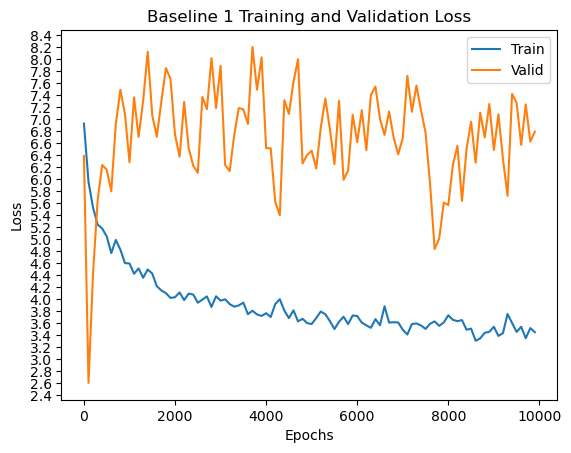

In [86]:
showPlot('Baseline 1',baseline1_plot_train_losses,baseline1_plot_valid_losses,n_iter,plot_every)

In [87]:
evaluateRandomly(baseline1_encoder, baseline1_decoder, n=10)

> 1 lb orange slice candy, cut up 2 c  pecans; chopped 8 oz dates; cut up 1 c  coconut, grated 2 c  flour; divided 1 c  butter 1 1/2 c  sugar 4    eggs 1 ts vanilla 1 ts baking soda 1/2 ts salt 1/2 c  buttermilk 1/4 c  orange juice 1/4 c  lemon juice 1/4 c  sugar 1/4 c  butter
= preheat the oven to 300 f. generously grease and flour a tube pan ; set aside . mix together the candy , pecans , dates , coconut and 1/4 cup of the flour ; set aside . cream the butter and sugar until fluffy . beat in the eggs , one at a time . stir in the vanilla . mix together the baking soda , salt and remaining 13/4 cup flour ; add alternately with the buttermilk to the butter mixture . add the nut mixture ; mix well . pour the batter into a prepared pan and bake for two hours ; remove from the oven . in a small saucepan , combine the orange juice , lemon juice , sugar and butter . cook until the sugar is dissolved . spoon the glaze over the warm cake .
< combine all ingredients in a bowl . mix well . add 

**Implementation of Baseline 2: RNN with Attention**

In [88]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        _, hidden = self.gru(embedded, hidden)

        attn_weights = F.softmax(torch.bmm(hidden, encoder_outputs.T.unsqueeze(0)),dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))

        concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        output = F.log_softmax(self.out(concat_output), dim=1)

        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


**Implementation of Baseline 2: Train method for RNN with attention**

In [89]:
teacher_forcing_ratio = 1.0


def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [91]:
teacher_forcing_ratio = 1.0
def valid_attn(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length


**Implementation of Baseline 2: Train iter method for RNN with attention**

In [92]:
def trainIters_attn(encoder, decoder, n_iters,print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_train_losses = []
    plot_valid_losses = []
    print_train_loss_total = 0  # Reset every print_every
    plot_train_loss_total = 0  # Reset every plot_every
    print_valid_loss_total = 0  # Reset every print_every
    plot_valid_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs))
                      for i in range(n_iters)]
    validation_pairs = [tensorsFromPair(random.choice(valid_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        training_input_tensor = training_pair[0]
        training_target_tensor = training_pair[1]

        valid_pair = validation_pairs[iter - 1]
        valid_input_tensor = valid_pair[0]
        valid_target_tensor = valid_pair[1]

        train_loss = train_attn(training_input_tensor, training_target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_train_loss_total += train_loss
        plot_train_loss_total += train_loss
        
        valid_loss = valid_attn(valid_input_tensor, valid_target_tensor, encoder,
             decoder, criterion)
        print_valid_loss_total += valid_loss
        plot_valid_loss_total += valid_loss

        if iter % print_every == 0:
            print_train_loss_avg = print_train_loss_total / print_every
            print_train_loss_total = 0
            print_valid_loss_avg = print_valid_loss_total / print_every
            print_valid_loss_total = 0
            print('%s (%d %d%%) Train Loss: %.4f | Validation Loss: %.4f' % (timeSince(start, iter / n_iters),
                                                                             iter, iter / n_iters * 100,
                                                                             print_train_loss_avg, print_valid_loss_avg))
        if iter % plot_every == 0:
            plot_train_loss_avg = plot_train_loss_total / plot_every
            plot_train_losses.append(plot_train_loss_avg)
            plot_train_loss_total = 0
            
            plot_valid_loss_avg = plot_valid_loss_total / plot_every
            plot_valid_losses.append(plot_valid_loss_avg)
            plot_valid_loss_total = 0
    return plot_train_losses,plot_valid_losses


**Implementation of Baseline 2: Initialising instance of RNN with attention**

In [93]:
hidden_size = 256
n_iter = 10000
plot_every = 100
print_every = 100
baseline2_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
baseline2_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
plot_train_losses,plot_valid_losses = trainIters_attn(baseline2_encoder, baseline2_decoder, 10000, print_every=1000)

4m 46s (- 43m 1s) (1000 10%) Train Loss: 5.0191 | Validation Loss: 5.5488
9m 53s (- 39m 33s) (2000 20%) Train Loss: 4.1724 | Validation Loss: 7.5875
14m 54s (- 34m 47s) (3000 30%) Train Loss: 4.0042 | Validation Loss: 7.3723
19m 33s (- 29m 19s) (4000 40%) Train Loss: 3.8231 | Validation Loss: 6.8138
24m 12s (- 24m 12s) (5000 50%) Train Loss: 3.7011 | Validation Loss: 6.6873
28m 51s (- 19m 14s) (6000 60%) Train Loss: 3.6967 | Validation Loss: 6.7131
33m 28s (- 14m 20s) (7000 70%) Train Loss: 3.6414 | Validation Loss: 6.4232
38m 11s (- 9m 32s) (8000 80%) Train Loss: 3.5757 | Validation Loss: 6.6934
42m 53s (- 4m 45s) (9000 90%) Train Loss: 3.5985 | Validation Loss: 6.9902
47m 38s (- 0m 0s) (10000 100%) Train Loss: 3.5372 | Validation Loss: 6.4692


**Implementation of Baseline 2: Evaluation method for RNN with Attention**

In [94]:
def evaluate_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [95]:
def evaluateRandomly_attn(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention= evaluate_attn(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [96]:
evaluateRandomly_attn(baseline2_encoder, baseline2_decoder)

> 1 c  chopped onion 14 oz canned chopped green chiles - drained 1/2 ts ground cumin 1/2 ts oregano 15 oz tomato sauce 1/2 c  chicken broth 2 c  cooked chicken breast chunks 3 c  cooked rice 1 c  dairy sour cream 8 oz cheddar cheese, shredded - (divided) 1 1/2 c  crushed corn chips
= combine onions , chiles , oregano , tomato sauce , and broth in 1-1/2 quart microproof baking dish . cover and cook on high -lrb- maximum power -rrb- 10 minutes ; stir after 5 minutes . add chicken ; stir . set aside . combine rice and sour cream in shallow greased 2-1/2 quart microproof baking dish . sprinkle with 1 cup cheddar cheese ; pour chicken mixture over cheese . top with remaining 1 cup cheddar cheese . cook uncovered on high 5 minutes .
< combine all ingredients in a large bowl . cover and refrigerate . <EOS>

> 1 lb ground pork clove garlic; crushed 2    green onions; chopped 1 lg egg 1 tb soy sauce 1 tb cornstarch 2 ts dry sherry 1/4 ts salt 1 ts sesame oil 1/4 ts pepper 1/2 ts fresh ginger; g

**Extension 1: Data Preprocessing**

In [256]:
# Recipe stopwords that commonly appear that do not represent any ingredients (used to preprocess it)
# This list was generated by ChatGPT3.5 + some of the words are added based on my experiments
recipe_stopwords = [
    'preheat', 'oven', 'bake', 'baking', 'baked', 'bakes',
    'minutes', 'hour', 'hours', 'minutes', 'second', 'seconds',
    'degrees', 'celsius', 'fahrenheit',
    'medium', 'low', 'high', 'heat','cold', 'stir', 'simmer', 'boil', 'cook', 'grill',
    'whisk', 'mix', 'combine', 'fold', 'blend', 'puree', 'chop', 'dice', 'slice',
    'peel', 'mince', 'drizzle', 'sprinkle', 'garnish', 'marinate', 'brush',
    'refrigerate', 'chill', 'cool', 'freeze', 'thaw', 'room', 'temperature',
    'bowl', 'plate', 'pan', 'pot', 'skillet', 'saucepan', 'baking', 'dish',
    'tray', 'oven', 'sheet', 'foil', 'parchment', 'paper', 'whisk', 'spatula',
    'spoon', 'knife', 'cutting', 'board', 'tongs', 'fork', 'mixer', 'blender',
    'food', 'processor', 'grater', 'peeler', 'sifter', 'rolling', 'pin', 'oven', 
    'mitts', 'rack', 'cooling', 'wire', 'timer', 'timer', 'recipe', 'directions', 
    'ingredients', 'instructions', 'method', 'step', 'steps', 'serve', 'serving', 
    'makes', 'yield', 'yield:', 'yields', 'size', 'number', 'portion', 'portions', 
    'note', 'notes', 'tip', 'tips', 'variations', 'version', 'versions', 'credit', 
    'credits', 'source', 'sources', 'adapted', 'adaptation', 'adaptations', 'based', 
    'courtesy', 'original', 'author', 'authors', 'website', 'link', 'links', 'video', 
    'videos', 'facebook', 'instagram', 'twitter', 'pinterest', 'youtube', 'email', 
    'subscribe', 'rss', 'save', 'print', 'rate', 'comment', 'share', 'subscribe', 
    'like', 'love', 'follow', 'pin', 'pinning', 'tweet', 'email', 'yum', 'instagram', 
    'snapchat', 'facebook', 'twitter', 'pinterest', 'linkedin', 'reddit', 'tumblr', 
    'whatsapp', 'telegram', 'messenger', 'sms', 'message', 'chat', 'print', 'kitchen', 
    'tip', 'tips', 'trick', 'tricks', 'hack', 'hacks', 'kitchen', 'kitchens', 'home', 
    'homes', 'family', 'families', 'friend', 'friends', 'guest', 'guests', 'love', 
    'lover', 'lovers', 'party', 'parties', 'holiday', 'holidays', 'season', 'seasons', 
    'occasion', 'occasions', 'day', 'days', 'night', 'nights', 'morning', 'mornings', 
    'afternoon', 'afternoons', 'evening', 'evenings', 'week', 'weeks', 'month', 'months', 
    'year', 'years', 'today', 'tomorrow', 'yesterday', 'fresh', 'from', 'the', 'store', 
    'grocery', 'groceries', 'shop', 'shopping', 'shopping', 'list', 'lists', 'order', 
    'orders', 'online', 'offline', 'local', 'farm', 'market', 'markets', 'buy', 'purchase', 
    'sell', 'sold', 'sold', 'out', 'brand', 'brands', 'company', 'companies', 'product', 
    'products', 'item', 'items', 'stock', 'store', 'stores', 'store', 'cupboard', 'pantry', 
    'cabinet', 'cabinets', 'shelf', 'shelves', 'freezer', 'fridge', 'refrigerator', 'appliance', 
    'appliances', 'equipment', 'accessory', 'accessories', 'tool', 'tools', 'utensil', 'utensils', 
    'gadget', 'gadgets', 'ingredient', 'ingredients', 'shop', 'shopping', 'store', 'supermarket', 
    'grocery', 'groceries', 'product', 'products', 'item', 'items', 'market', 'markets', 'local', 
    'online', 'organic', 'fresh', 'best', 'quality', 'brand', 'brands', 'company', 'companies', 
    'sale', 'discount', 'offer', 'deal', 'special', 'new', 'hot', 'trend', 'trending', 'popular', 
    'favorite', 'essential', 'basic', 'must', 'need', 'want', 'buy', 'purchase', 'sell', 'sold', 
    'stock', 'top', 'high', 'low', 'price', 'cost', 'cheap', 'expensive', 'affordable', 'budget', 
    'value', 'range', 'selection', 'variety', 'choice', 'option', 'flavor', 'flavors', 'taste', 
    'tastes', 'texture', 'textures', 'aroma', 'aromas', 'color', 'colors', 'colour', 'colours', 
    'style', 'styles', 'type', 'types', 'kind', 'kinds', 'size', 'sizes', 'amount', 'portion', 
    'portions', 'quantity', 'measure', 'measures', 'weight', 'volume', 'piece', 'pieces', 'bit', 
    'bits', 'part', 'parts', 'whole', 'half', 'quarter', 'third', 'eighth', 'sixteenth', 'tablespoon', 
    'tablespoons', 'teaspoon', 'teaspoons', 'cup', 'cups', 'pint', 'pints', 'quart', 'quarts', 
    'gallon', 'gallons', 'ounce', 'ounces', 'pound', 'pounds', 'gram', 'grams', 'kilogram', 
    'kilograms', 'liter', 'liters', 'milliliter', 'milliliters', 'inch', 'inches', 'foot', 
    'feet', 'yard', 'yards', 'meter', 'meters', 'centimeter', 'centimeters', 'kilometer', 
    'kilometers', 'mile', 'miles', 'small', 'medium', 'large', 'size', 'sized', 'big', 'bigger', 
    'biggest', 'tiny', 'tinier', 'tiniest', 'mini', 'minis', 'miniature', 'micro', 'miniature', 
    'average', 'normal', 'standard', 'fine', 'finest', 'finer', 'best', 'better', 'worst', 
    'least', 'most', 'more', 'fewer', 'few', 'lots', 'plenty', 'ton', 'tons', 'great', 'greater', 
    'greatest', 'awesome', 'fantastic', 'amazing', 'good', 'better', 'best', 'excellent', 
    'wonderful', 'remarkable', 'outstanding', 'brilliant', 'superb', 'fabulous', 'terrific', 
    'exceptional', 'phenomenal', 'splendid', 'extraordinary', 'magnificent', 'top-notch', 
    'first-rate', 'high-quality', 'premium', 'deluxe', 'luxury', 'high-end', 'superior', 
    'supreme', 'ultimate', 'divine', 'heavenly', 'fab', 'fancy', 'lux', 'lush', 'posh', 
    'swanky', 'chic', 'classy', 'elegant', 'fashionable', 'stylish', 'trendy', 'up-to-date', 
    'hip', 'cool', 'trendsetting', 'cutting-edge', 'innovative', 'forward-thinking', 
    'progressive', 'modern', 'contemporary', 'sleek', 'chic', 'tasteful', 'sophisticated', 
    'cultured', 'polished', 'refined', 'classic', 'timeless', 'nostalgic', 'vintage','medium', 
    'large', 'small','chopped','lb','finely','thinly','desired','lg','md','each','or','can','delicious','bout','for','as']


In [257]:
MAX_LENGTH = 150
import re
def clean_text(text,stopwords,ingredients = False):
    # Define regular expression pattern to match numeric values and units
    amount_pattern = r'\b[\d.]+(?:\s*(?:g|kg|l|ml|tsp|tbsp|cup|pint|quart|oz|c|tb|ts|b|ea|pk|t|can|cups|cn|ounce)\b)?'
    # Remove numeric values and units from the text
    text = re.sub(amount_pattern, '', text)

    # Remove irrelevant information like advertisements, website navigation elements, etc.
    # Assuming such information may be enclosed within angle brackets or parentheses
    bracket_pattern = r'<[^>]*>|(\([^)]*\))'
    remove_words = r'-rrb-|-lrb-'
    # Remove text inside angle brackets and parentheses
    cleaned_text = re.sub(bracket_pattern, '', text)
    cleaned_text = re.sub(remove_words, '', cleaned_text)
    # Create a regex pattern to match the specified stopwords surrounded by spaces
    if ingredients:
        pattern = r'\b(?:' + '|'.join(re.escape(word) for word in stopwords) + r')\b'
        cleaned_text = re.sub(pattern, '', cleaned_text)

    # Handle missing data and standardize text format
    cleaned_text = cleaned_text.lower()  # Convert text to lowercase
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)  # Remove punctuation
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()  # Remove extra whitespaces
    return cleaned_text

In [258]:
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def average_length (pairs):
    ing_len = []
    rec_len = []
    for pair in pairs:
        ing_len.append(len(pair[0]))
        
        

def filterPairs_test(pairs):
    filtered_pairs = []
    saved_indices = []
    for i, pair in enumerate(pairs):
        if filterPair(pair):
            filtered_pairs.append(pair)
            saved_indices.append(i)
    return filtered_pairs, saved_indices

In [254]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, train_pairs, valid_pairs, test_pairs = readLangs(reverse)
    print("Read %s sentence pairs" % len(train_pairs))
    train_pairs = filterPairs(train_pairs)
    valid_pairs = filterPairs(valid_pairs)
    test_pairs, test_indices = filterPairs_test(test_pairs)
    print("Trimmed to %s sentence train pairs" % len(train_pairs))
    print("Trimmed to %s sentence test pairs" % len(test_pairs))
    print("Trimmed to %s sentence dev pairs" % len(valid_pairs))
    print("Counting words...")
    for pair in train_pairs:
        pair[0] = clean_text(pair[0],recipe_stopwords,True)
        pair[1] = clean_text(pair[1],recipe_stopwords,False)
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in valid_pairs:
        pair[0] = clean_text(pair[0],recipe_stopwords,True)
        pair[1] = clean_text(pair[1],recipe_stopwords,False)
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in test_pairs:
        pair[0] = clean_text(pair[0],recipe_stopwords,True)
        pair[1] = clean_text(pair[1],recipe_stopwords,False)
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, train_pairs, valid_pairs, test_pairs, test_indices

input_lang, output_lang, train_pairs, valid_pairs, test_pairs ,test_indices= prepareData('ingredients', 'recipe', False)
print(random.choice(train_pairs))

Read 101340 sentence pairs
Trimmed to 79894 sentence train pairs
Trimmed to 629 sentence test pairs
Trimmed to 644 sentence dev pairs
Counting words...
Counted words:
Ingredients 16435
Recipe 31230
['flour salt clarified butter melted yogurt water filling oil for frying', 'sift together flour and salt add melted butter yogurt and water to make a stiff dough knead until smooth and elastic roll out very thin on floured board cut into to inch circles place a small amount of filling in center leaving edges free fold in half and seal edges heat oil and fry curry puffs until golden drain and serve with mint or coriander leaf chutney']


In [225]:
hidden_size = 256
n_iter = 10000
plot_every = 100
print_every = 100
extension1_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
extension1_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
plot_extension1_train_losses,plot_extension1_valid_losses = trainIters_attn(extension1_encoder, extension1_decoder, 10000, print_every=1000)

3m 13s (- 29m 0s) (1000 10%) Train Loss: 5.4755 | Validation Loss: 6.9626
6m 18s (- 25m 13s) (2000 20%) Train Loss: 4.5847 | Validation Loss: 6.7204
9m 21s (- 21m 51s) (3000 30%) Train Loss: 4.3709 | Validation Loss: 6.5502
12m 22s (- 18m 33s) (4000 40%) Train Loss: 4.2365 | Validation Loss: 6.3733
15m 24s (- 15m 24s) (5000 50%) Train Loss: 4.1431 | Validation Loss: 6.5894
18m 36s (- 12m 24s) (6000 60%) Train Loss: 4.1167 | Validation Loss: 6.8025
21m 42s (- 9m 18s) (7000 70%) Train Loss: 4.0555 | Validation Loss: 6.7621
24m 43s (- 6m 10s) (8000 80%) Train Loss: 3.9978 | Validation Loss: 6.4334
27m 50s (- 3m 5s) (9000 90%) Train Loss: 4.0285 | Validation Loss: 6.7790
30m 56s (- 0m 0s) (10000 100%) Train Loss: 3.9457 | Validation Loss: 6.9520


<Figure size 640x480 with 0 Axes>

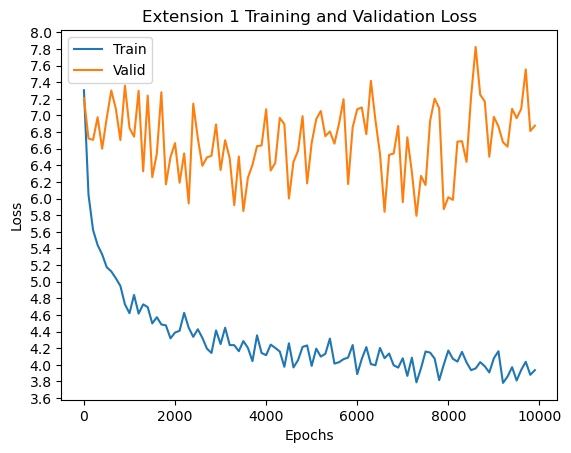

In [226]:
showPlot('Extension 1',plot_extension1_train_losses,plot_extension1_valid_losses,n_iter,plot_every)

In [227]:
evaluateRandomly_attn(extension1_encoder, extension1_decoder)

> coarsely sweet onion such as vidalia cold chicken broth all fat removed thoroughly ripe avocados buttermilk dr almond extract pn of sugar salt to taste jalapeno peppers seeds and veins removed cut into very dice to tablespoons minced cilantro crisp tortilla chips to accompany
= place the onions in a blender or processor and add of the puree as fine as possible peel and chunk in of the avocados reserving the remaining half for garnish puree again adding broth as necessary transfer the soup to a bowl add any remaining broth the buttermilk to the blender and whir briefly to pick as much avocado as possible add to the soup along with the extract and sugar if stir well taste and adjust the salt peel the remaining half avocado cut into very thin slices divide soupamong six serving bowls and top with the sliced avocado and coriander serve accompanied by the tortilla chips
< in a saucepan combine all ingredients except the chicken and bring to a boil reduce heat and simmer for minutes or unt

**Extension 2: Stacking Layers**

In [222]:
class EncoderRNN_Layers(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(EncoderRNN_Layers, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)


In [223]:
class AttnDecoderRNN_Layers(nn.Module):
    def __init__(self, hidden_size, output_size,num_layers, dropout_p=0.1, max_length=200):
        super(AttnDecoderRNN_Layers, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.num_layers = num_layers

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, num_layers=self.num_layers)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        _, hidden = self.gru(embedded, hidden)
        attn_weights = F.softmax(torch.bmm(hidden[-1].unsqueeze(0), encoder_outputs.T.unsqueeze(0)),dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))

        concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [228]:
hidden_size = 256
n_iter = 10000
plot_every = 100
print_every = 100
extension2_encoder = EncoderRNN_Layers(input_lang.n_words, hidden_size, num_layers=2).to(device)
extension2_decoder = AttnDecoderRNN_Layers(hidden_size, output_lang.n_words, num_layers=2, dropout_p=0.1).to(device)
plot_extension2_train_losses,plot_extension2_valid_losses = trainIters_attn(extension2_encoder, extension2_decoder, 10000, print_every=1000)

KeyboardInterrupt: 

In [ ]:
# evaluateRandomly_attn(extension2_encoder, extension2_decoder)

In [ ]:
def evaluateRandomly_attn_test(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(test_pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention= evaluate_attn(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
# evaluateRandomly_attn_test(extension2_encoder, extension2_decoder)

**Paper implementation: NN Swap baseline model implementation**

In [221]:
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors

def fit_nearest_neighbor(train_pair, max_length=MAX_LENGTH):
    # Precompute padded pairs and norms for all recipes in the dataset
    padded_pairs = []
    norms = []
    for pair in train_pair:
        # Convert sentence to tensor
        current_pair = tensorFromSentence(input_lang, pair[0])
        # Pad tensor
        padding_length = max(0, max_length - len(current_pair))
        padded_pair = torch.cat((current_pair.squeeze(), torch.zeros(padding_length, dtype=torch.long).to(device)))
        # Append to list
        padded_pairs.append(padded_pair)
    
    # Convert list of tensors to a single tensor
    padded_pairs_tensor = torch.stack(padded_pairs)
    
    # Fit NearestNeighbors model
    nn_model = NearestNeighbors(metric='cosine')
    nn_model.fit(padded_pairs_tensor.cpu().numpy())  # Convert tensor to numpy array
    return nn_model
nn_model = fit_nearest_neighbor(train_pairs)


In [219]:
test = tensorFromSentence(input_lang, test_pairs[10][0])
print(test_pairs[10][0])
# Pad test tensor
padding_length = max(0, MAX_LENGTH - len(test))
test_padded = torch.cat((test.squeeze(), torch.zeros(padding_length, dtype=torch.long).to(device)))
pred = nn_model.kneighbors([test_padded.cpu().numpy()], n_neighbors=4, return_distance=False)[0]
print(train_pairs[pred[1]][0])

2 ts olive oil 1/2 ts dried thyme 1 sm onion(s), chopped 1/2 ts dried marjoram 2    stalks celery, chopped 1 3/4 c  beef stock 2    garlic clove(s), minced 1    bay leaf 1 c  bulgur 1 tb parsley, chopped 1/2 ts dried rubbed sage salt and pepper to taste
3/4 cn brown rice; uncooked 1/2 c  dried lentils; rinsed 1/2 c  chopped onions 1/2 c  sliced celery 1/2 c  sliced carrots 1/4 c  snipped fresh parsley 1 ts italian seasoning 1    garlic clove; minced 1    bay leaf 2 1/2 c  [stock] 14 1/2 oz canned tomatoes, peeled; cut 1 tb cider vinegar
combine all ingredients in dutch oven or large saucepan ; bring to a boil . reduce heat and simmer , uncovered , stirring occasionally , for 55 minutes to 1 hour , or until rice is tender . remove and discard bay leaf .


**Ingredients Extraction from Recipe**

In [33]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
nltk.download('stopwords')

# Sample text
text = ' '.join(pair[0] for pair in train_pairs)
tokens = word_tokenize(text)
# Remove stopwords
stop_words = set(stopwords.words('english') + recipe_stopwords)
tokens = [word for word in tokens if word not in stop_words]
# Remove everything except for those that are Nouns
pos_tags = pos_tag(tokens)
tokens = [word for word, pos in pos_tags if pos == 'NN'or pos == 'NNS']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
from gensim.models import Phrases
# Create phrases
# Define phrases to be forced
force_phrases = {"seeds", "seed","syrups", "syrup", "juice", "juices","cream","creams","leaf","leaves","flavoured","flavours","cooled","cool","pieces"}
# Create phrases
irrelevant_words = {'bring_boil','smooth','food','temperature','blender','let', 'well', 'along', 'cut','least', 'hours', 'desired', 'minutes', 'allow', 'remove', 'mixed', 'serve', 'bring', 'soften', 'fold', 'stirring', 'serving', 'simmer', 'sit', 'heat', 'stir', 'remove_heat', 'combine', 'pour', 'gently', 'blend', 'puree', 'chilled', 'freeze', 'container', 'room_temperature', 'saucepan', 'mixture', 'consistency','turn','mill','trays','bowls'}
bigram = Phrases([tokens], min_count=5, threshold=3)
from gensim.models.phrases import Phraser
bigram_phraser = Phraser(bigram)
tokens_with_phrases = bigram_phraser[tokens]
token_counts = Counter(tokens_with_phrases)
# Select top k tokens by occurrences
k = 10000
unique_tokens_with_phrases = [token for token, count in token_counts.most_common(k) if token not in force_phrases and token not in irrelevant_words]


In [36]:
def prerocess_for_count (sentence):
    sentence_tokens = word_tokenize(sentence.lower())
    return [word for word in sentence_tokens if word not in stop_words]

def count_ingredients(unique_tokens_with_phrases, sentence_tokens):
    final_phrases = []
    i = 0
    while i < len(sentence_tokens):
        phrase = '_'.join(sentence_tokens[i:i+2])
        if phrase in unique_tokens_with_phrases:
            final_phrases.append(phrase)
            i += 2
        elif sentence_tokens[i] in unique_tokens_with_phrases:
            final_phrases.append(sentence_tokens[i])
            i += 1
        else:
            phrase = '_'.join(sentence_tokens[i:i+4])
            i += 1
    return set(final_phrases)


In [37]:
test_ing = clean_text('2 c sugar, 1/4 c lemon juice, 1 c water, 1/3 c orange juice, 8 c strawberries')
gold_recipe = 'combine <sugar> and <water> in medium saucepan . Heat , stirring , until <sugar> dissolves , then boil 5 minutes . cool . force <strawberries> through food mill or blend in blender or food processor . strain to remove seeds , if desired . blend the puree and <lemon juice> and <orange juice> into syrup . pour into freezer trays and freeze . remove from freezer 20 minutes before serving . turn into bowl and stir until smooth .'
generated_recipe = 'Combine <sugar> and <water> in a medium saucepan . Heat, stirring, until <sugar> dissolves . Bring to a boil and let simmer for 5 minutes . Remove from heat and allow to cool . In a blender or food processor , combine <strawberries> and <cantaloupe> . Blend until smooth . Strain the mixture to remove any seeds and fibers, if desired. Stir the puree into the cooled syrup along with the <lemon juice> and <orange juice> . Pour the mixture into a large bowl and gently fold in the <vanilla ice cream> until well mixed . Freeze in a container for at least 4 hours . Before serving , let it sit at room temperature for 20 minutes to soften . Stir well to achieve a smooth consistency and serve chilled .'

sentence_tokens_test = prerocess_for_count(test_ing)
sentence_tokens_gold_recipe = prerocess_for_count(gold_recipe)
sentence_tokens_generated_recipe = prerocess_for_count(generated_recipe)

print (count_ingredients(unique_tokens_with_phrases,sentence_tokens_test))
print(count_ingredients(unique_tokens_with_phrases,sentence_tokens_gold_recipe))
print(count_ingredients(unique_tokens_with_phrases,sentence_tokens_generated_recipe))

{'strawberries', 'sugar', 'lemon_juice', 'water', 'orange_juice'}
{'strawberries', 'sugar', 'lemon_juice', 'water', 'orange_juice'}
{'strawberries', 'sugar', 'lemon_juice', 'cantaloupe', 'vanilla_ice', 'water', 'orange_juice'}


In [38]:
def eval_test(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length


In [39]:
def eval_test_atnn(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length


In [210]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
nltk.download('wordnet')

def check_test_set(encoder, decoder,test_pairs,attention_status,unique_tokens_with_phrases):
    start = time.time()
    test_loss_total = 0  # Reset every print_every

    testing_pairs = [tensorsFromPair(pair) for pair in test_pairs]
    criterion = nn.NLLLoss()
    avg_given = []
    avg_extra = []
    bleu_scores = []
    meteor_scores = []
    generated_words = []
    for i in range (len(testing_pairs)):
        test_pair = testing_pairs[i]
        test_input_tensor = test_pair[0]
        test_target_tensor = test_pair[1]
        if attention_status:
            test_loss = eval_test_atnn(test_input_tensor, test_target_tensor, encoder,
            decoder, criterion)
            ingredients = count_ingredients(prerocess_for_count (test_pairs[i][0]),unique_tokens_with_phrases)
            output_words, attention= evaluate_attn(encoder, decoder, test_pairs[i][0])
            output_words=' '.join(output_words)
            generated_words.append(output_words)
            used_ingredients = count_ingredients(prerocess_for_count (output_words),unique_tokens_with_phrases)
            ingredients_stated = max(1,len(ingredients))
            used_given = len(used_ingredients & ingredients) / ingredients_stated
            avg_given.append(used_given)
            extra_items = max(0,len(used_ingredients) - len(ingredients))
            avg_extra.append(extra_items)

        else:
            test_loss = eval_test(test_input_tensor, test_target_tensor, encoder,
             decoder, criterion)
            ingredients = count_ingredients(prerocess_for_count (test_pairs[i][0]),unique_tokens_with_phrases)
            output_words=' '.join(evaluate(encoder, decoder, test_pairs[i][0]))
            generated_words.append(output_words)
            used_ingredients = count_ingredients(prerocess_for_count (output_words),unique_tokens_with_phrases)
            ingredients_stated = max(1,len(ingredients))
            used_given = len(used_ingredients & ingredients) / ingredients_stated
            avg_given.append(used_given)
            extra_items = max(0,len(used_ingredients) - len(ingredients))
            avg_extra.append(extra_items)

        # Calculate BLEU Score
        reference = [test_pairs[i][1].split()]  # Assuming pair[1] is the target sentence
        hypothesis = [output_words.split()]
        bleu_score = corpus_bleu(reference, hypothesis)
        bleu_scores.append(bleu_score)
        # Calculate METEOR score
        metor_reference = test_pairs[i][1].split()
        if attention_status:
            meteor_hypothesis, _ = evaluate_attn(encoder, decoder, test_pairs[i][0])
        else:
            meteor_hypothesis = evaluate(encoder, decoder, test_pairs[i][0])
        meteor_score_value = meteor_score([metor_reference], meteor_hypothesis)
        meteor_scores.append(meteor_score_value)
        test_loss_total += test_loss
    final_loss = test_loss_total / len(testing_pairs)
    return final_loss,avg_given,avg_extra,bleu_scores,meteor_scores,generated_words


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\manut\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Performance Evaluation for Baseline 1**

In [182]:
final_loss,avg_given,avg_extra,bleu_scores,meteor_scores,generated_words= check_test_set(baseline1_encoder, baseline1_decoder,test_pairs,False,unique_tokens_with_phrases)

In [164]:
print (np.mean(meteor_scores))

0.1601545863980096


In [165]:
print (np.mean(bleu_scores))

8.265853442317835e-232


In [183]:
print (generated_words[0])

as eggs combine minutes have bread grease dough flour or stirring combined blend hot grease sugar if whites and improvise blend cookie crumbs blend hot grease temperature over blend cookie crumbs blend form and batte loaves cups tearing blend to flour or run edge beat eggs occasionally on ingredients blend batte corn combine one hour blend <EOS>


In [215]:
final_loss,avg_given,avg_extra,bleu_scores,meteor_scores,generated_words= check_test_set(baseline2_encoder, baseline2_decoder,test_pairs,True,unique_tokens_with_phrases)

C:\Users\manut\anaconda3\envs\fit5217\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\manut\anaconda3\envs\fit5217\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\manut\anaconda3\envs\fit5217\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram or

In [216]:
print (np.mean(meteor_scores))

0.16283798307453887


In [217]:
print (np.mean(bleu_scores))

8.824007937036293e-232


In [ ]:
print (np.mean(avg_extra))

In [ ]:
final_loss,avg_given,avg_extra = check_test_set(extension2_encoder, extension2_decoder,test_pairs,True,unique_tokens_with_phrases)

In [176]:
print (test_indices)

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 19, 20, 21, 22, 27, 29, 30, 31, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 54, 55, 57, 58, 60, 61, 62, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 77, 80, 81, 82, 83, 85, 86, 87, 89, 91, 93, 95, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 131, 132, 133, 134, 135, 138, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198, 199, 200, 202, 203, 205, 206, 207, 208, 211, 212, 213, 214, 215, 216, 217, 218, 220, 222, 225, 226, 227, 228, 229, 230, 231, 232, 234, 236, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 261, 262, 265, 266, 268, 269, 270, 271, 273,

In [209]:
test_indices_excel = []
for i in range (len(test_indices)):
    test_indices_excel.append(test_indices[i] + 1)

import csv
def write_to_excel(file_name, column_name, data, indices):
    # Open the existing Excel file in read mode
    with open(file_name, 'r') as file:
        reader = csv.reader(file)
        rows = list(reader)

    # Find the column index of the specified column name
    header = rows[0]
    try:
        column_index = header.index(column_name)
    except ValueError:
        print(f"Column '{column_name}' not found in the Excel file.")
        return

    # Write data into the specified column at the specified indices
    for i, index in enumerate(indices):
        if index < len(rows):
            row_index = index + 1  # Adjust for header row
            row = rows[row_index]
            row[column_index] = str(data[i])  # Convert data to string

    # Write the modified rows back to the Excel file
    with open(file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(rows)


# Example usage:
file_name = "generated_012345678.csv"
column_name = "Generated Recipe - Baseline 1"
write_to_excel(file_name, column_name, generated_words, test_indices_excel)
